In [5]:
import time
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T

import cv2
import numpy as np
import os
from PIL import Image
import torchvision.transforms as T
from tqdm import tqdm
from glob import glob
from pathlib import Path

In [6]:


# Load pretrained landmark model (68 points, 2D)
device = 'cuda' if torch.cuda.is_available() else 'cpu'


In [7]:
device

'cuda'

In [8]:
def img_to_patches(x, patch_size):
    # x: (B, C, H, W)
    B, C, H, W = x.shape
    assert H % patch_size == 0 and W % patch_size == 0
    ph, pw = patch_size, patch_size
    nh, nw = H // ph, W // pw
    x = x.reshape(B, C, nh, ph, nw, pw)
    x = x.permute(0,2,4,3,5,1).reshape(B, nh*nw, ph*pw*C)  # (B, N, patch_dim)
    return x, (nh, nw)

In [9]:
def patches_to_img(patches, patch_size, nh_nw, C):
    # patches: (B, N, patch_dim)
    B, N, D = patches.shape
    nh, nw = nh_nw
    ph = pw = patch_size
    x = patches.reshape(B, nh, nw, ph, pw, C).permute(0,5,1,3,2,4).reshape(B, C, nh*ph, nw*pw)
    return x

In [10]:
def mask_to_patch_mask(mask, patch_size):
    # mask: (B,1,H,W) binary [0,1]
    B, _, H, W = mask.shape
    ph = pw = patch_size
    nh, nw = H//ph, W//pw
    mask = mask.reshape(B, 1, nh, ph, nw, pw)
    mask = mask.mean(dim=(3,5))  # (B,1,nh,nw)
    patch_mask = (mask.view(B, nh*nw) > 0.1).float()  # (B, N)
    return patch_mask  # 1 where patch contains nos

In [11]:
def validate_files(img_dir, mask_dir, target_dir):
    img_dir, mask_dir, target_dir = map(Path, (img_dir, mask_dir, target_dir))
    valid_files = []
    for f in os.listdir(img_dir):
        if f.startswith("pre"):
            target_f = f.replace("pre", "post", 1)  # replace only first occurrence
            if (img_dir/f).exists() and (mask_dir/f).exists() and (target_dir/target_f).exists():
                valid_files.append((f, target_f))  # store input-target pair
    return valid_files

In [12]:
from pathlib import Path
from torch.utils.data import Dataset
import torch, cv2
import numpy as np

class NoseFolderDataset(Dataset):
    def __init__(self, img_dir, mask_dir, target_dir, size=256):
        self.img_dir = Path(img_dir)
        self.mask_dir = Path(mask_dir)
        self.target_dir = Path(target_dir)
        self.size = size
        self.file_pairs = validate_files(img_dir, mask_dir, target_dir)  # [(img_name, tgt_name), ...]

    def __len__(self):
        return len(self.file_pairs)

    def _read_rgb(self, path):
        img = cv2.imread(str(path), cv2.IMREAD_COLOR)
        if img is None:
            raise FileNotFoundError(f"Could not read image: {path}")
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (self.size, self.size), interpolation=cv2.INTER_AREA)
        return img

    def _read_mask(self, path):
        m = cv2.imread(str(path), cv2.IMREAD_GRAYSCALE)
        if m is None:
            raise FileNotFoundError(f"Could not read mask: {path}")
        m = cv2.resize(m, (self.size, self.size), interpolation=cv2.INTER_NEAREST)
        m = (m > 127).astype(np.uint8)  # 0/1
        return m

    def __getitem__(self, idx):
        fname, target_f = self.file_pairs[idx]
        img_path    = self.img_dir / fname
        mask_path   = self.mask_dir / fname
        target_path = self.target_dir / target_f

        img    = self._read_rgb(img_path)      # (H,W,3) RGB uint8
        target = self._read_rgb(target_path)   # (H,W,3) RGB uint8
        mask   = self._read_mask(mask_path)    # (H,W)    0/1

        # to tensors in [0,1]
        img_t    = torch.from_numpy(img).permute(2,0,1).float() / 255.0   # (3,H,W)
        target_t = torch.from_numpy(target).permute(2,0,1).float() / 255.0
        mask_t   = torch.from_numpy(mask).unsqueeze(0).float()            # (1,H,W) in {0,1}

        x = torch.cat([img_t, mask_t], dim=0)  # (4,H,W)

        return {
            "input": x,
            "target": target_t,
            "mask": mask_t,
            "input_file": str(img_path),
            "mask_file": str(mask_path),
            "target_file": str(target_path),
        }

In [13]:
IMG_DIR    = "/workspace/processed/train/A"
MASK_DIR   = "/workspace/nose_mask"
TARGET_DIR = "/workspace/processed/train/B"
ds = NoseFolderDataset(IMG_DIR, MASK_DIR, TARGET_DIR, size=256)

# check first sample
sample = ds[0]
print(sample["input"].shape, sample["target"].shape, sample["mask"].min().item(), sample["mask"].max().item())


torch.Size([4, 256, 256]) torch.Size([3, 256, 256]) 0.0 1.0


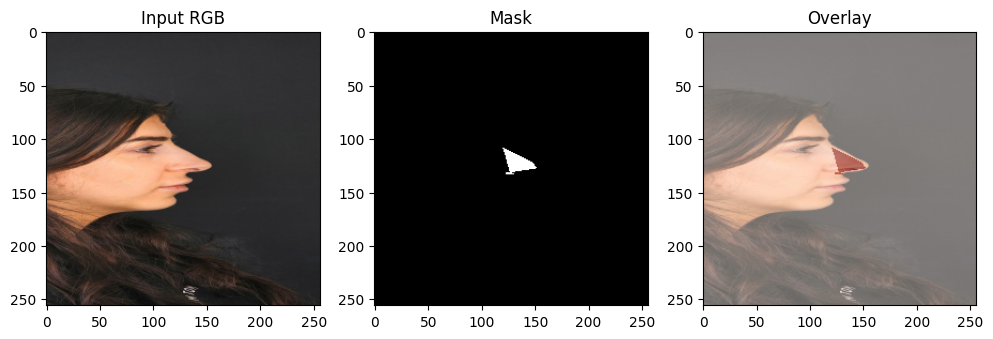

In [14]:
import matplotlib.pyplot as plt

sample = ds[0]
inp   = sample["input"][:3]   # take only RGB
mask  = sample["mask"][0]     # (H,W)
tgt   = sample["target"]

inp_np  = inp.permute(1,2,0).numpy()
tgt_np  = tgt.permute(1,2,0).numpy()
mask_np = mask.numpy()

plt.figure(figsize=(12,4))
plt.subplot(1,3,1); plt.imshow(inp_np); plt.title("Input RGB")
plt.subplot(1,3,2); plt.imshow(mask_np, cmap="gray"); plt.title("Mask")
plt.subplot(1,3,3); plt.imshow(inp_np); plt.imshow(mask_np, cmap="Reds", alpha=0.4); plt.title("Overlay")
plt.show()

In [15]:
# --------------------------- Transformer blocks ------------------------------

class MLP(nn.Module):
    def __init__(self, dim, mlp_ratio=4.0, drop=0.0):
        super().__init__()
        hidden = int(dim*mlp_ratio)
        self.fc1 = nn.Linear(dim, hidden)
        self.act = nn.GELU()
        self.fc2 = nn.Linear(hidden, dim)
        self.drop = nn.Dropout(drop)
    def forward(self, x):
        x = self.fc1(x); x = self.act(x); x = self.drop(x)
        x = self.fc2(x); x = self.drop(x)
        return x

class MHA_with_bias(nn.Module):
    def __init__(self, embed_dim, num_heads, attn_dropout=0.0):
        super().__init__()
        self.mha = nn.MultiheadAttention(embed_dim, num_heads, dropout=attn_dropout, batch_first=True)
    def forward(self, x, attn_bias=None):
        # x: (B,N,D); attn_bias: (B,N,N) floats added to logits
        B, N, D = x.shape
        if attn_bias is None:
            out, _ = self.mha(x, x, x, need_weights=False)
            return out
        outs = []
        for b in range(B):
            mask_b = attn_bias[b]  # (N,N)
            out_b, _ = self.mha(x[b:b+1], x[b:b+1], x[b:b+1], attn_mask=mask_b)
            outs.append(out_b)
        return torch.cat(outs, dim=0)

class TransformerBlock(nn.Module):
    def __init__(self, dim, heads, mlp_ratio=4.0, drop=0.0):
        super().__init__()
        self.norm1 = nn.LayerNorm(dim)
        self.attn  = MHA_with_bias(dim, heads, attn_dropout=drop)
        self.norm2 = nn.LayerNorm(dim)
        self.mlp   = MLP(dim, mlp_ratio, drop)
    def forward(self, x, attn_bias=None):
        x = x + self.attn(self.norm1(x), attn_bias=attn_bias)
        x = x + self.mlp(self.norm2(x))
        return x

class PatchEmbed(nn.Module):
    def __init__(self, in_ch, embed_dim, patch_size):
        super().__init__()
        self.patch_size = patch_size
        self.proj = nn.Linear((patch_size*patch_size*in_ch), embed_dim)
    def forward(self, x):
        patches, (nh, nw) = img_to_patches(x, self.patch_size)  # (B, N, patch_dim)
        x = self.proj(patches)  # (B, N, embed_dim)
        return x, (nh, nw)


In [16]:
# --------------------------- Generator (Transformer + Conv decoder) ----------

class ConvDecoder(nn.Module):
    def __init__(self, in_dim, out_ch=3, up_factor=8):
        super().__init__()
        self.body = nn.Sequential(
            nn.Conv2d(in_dim, 256, 3, padding=1), nn.GELU(),
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False),
            nn.Conv2d(256, 128, 3, padding=1),   nn.GELU(),
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False),
            nn.Conv2d(128, 64, 3, padding=1),    nn.GELU(),
            nn.Upsample(scale_factor=max(1, up_factor//4), mode='bilinear', align_corners=False),
            nn.Conv2d(64, out_ch, 3, padding=1)
        )
        self.res_scale = 0.25  # you can temporarily set 0.5 in early epochs

    def forward(self, feat):  # feat: (B, D, nh, nw)
        delta = self.body(feat)                 # (B, 3, H, W)
        return torch.tanh(delta) * self.res_scale

class NoseTransformer(nn.Module):
    def __init__(self, in_ch=4, out_ch=3, embed_dim=512, patch_size=8, depth=6, num_heads=8,
                 bias_pos=+1.0, bias_neg=-0.5):
        super().__init__()
        self.patch_size  = patch_size
        self.embed_dim   = embed_dim
        self.out_ch      = out_ch
        self.bias_pos    = bias_pos
        self.bias_neg    = bias_neg

        self.patch_embed = PatchEmbed(in_ch, embed_dim, patch_size)
        self.pos_embed   = None
        self.blocks      = nn.ModuleList([TransformerBlock(embed_dim, num_heads) for _ in range(depth)])
        self.decoder     = ConvDecoder(in_dim=embed_dim, out_ch=out_ch, up_factor=patch_size)

    def _build_attn_bias(self, patch_mask):
        pm = patch_mask.float()                   # (B,N)
        same = torch.einsum('bi,bj->bij', pm, pm) # nose↔nose
        q_is_nose = pm.unsqueeze(2)               # (B,N,1)
        k_not_nose = (1.0 - pm).unsqueeze(1)      # (B,1,N)
        nose_to_non = q_is_nose * k_not_nose      # (B,N,N)
        attn_bias = self.bias_pos * same + self.bias_neg * nose_to_non
        return attn_bias

    def forward(self, inp, patch_mask=None):
        """
        inp: (B, 4, H, W)  [RGB + mask]
        """
        B, _, H, W = inp.shape
        x, (nh, nw) = self.patch_embed(inp)        # (B, N, D)
        N = x.shape[1]

        if self.pos_embed is None or self.pos_embed.shape[1] != N:
            self.pos_embed = nn.Parameter(torch.zeros(1, N, self.embed_dim, device=x.device))
            nn.init.trunc_normal_(self.pos_embed, std=0.02)
        x = x + self.pos_embed

        attn_bias = self._build_attn_bias(patch_mask) if patch_mask is not None else None
        for blk in self.blocks:
            x = blk(x, attn_bias=attn_bias)

        feat = x.transpose(1, 2).reshape(B, self.embed_dim, nh, nw)  # (B, D, nh, nw)
        delta = self.decoder(feat)                                    # (B, 3, H, W)

        rgb  = inp[:, :3]
        m3   = inp[:, 3:4].repeat(1, 3, 1, 1)
        out  = torch.clamp(rgb + delta * m3, 0, 1)
        return out

# --------------------------- PatchGAN Discriminator --------------------------
class PatchDiscriminator(nn.Module):
    def __init__(self, in_ch=3, base_channels=64):
        super().__init__()
        # Input: (B, in_ch, H, W)
        # Output: (B, 1, H/16, W/16) patch realism map
        layers = []
        ch = base_channels
        layers += [nn.Conv2d(in_ch, ch, 4, stride=2, padding=1), nn.LeakyReLU(0.2, inplace=True)]

        layers += [nn.Conv2d(ch, ch*2, 4, stride=2, padding=1), nn.BatchNorm2d(ch*2), nn.LeakyReLU(0.2, inplace=True)]
        ch *= 2
        layers += [nn.Conv2d(ch, ch*2, 4, stride=2, padding=1), nn.BatchNorm2d(ch*2), nn.LeakyReLU(0.2, inplace=True)]
        ch *= 2
        layers += [nn.Conv2d(ch, ch*2, 4, stride=2, padding=1), nn.BatchNorm2d(ch*2), nn.LeakyReLU(0.2, inplace=True)]

        # final conv to 1-channel patch map
        layers += [nn.Conv2d(ch*2, 1, 4, padding=1)]

        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)


In [17]:
def erode_mask(mask, k=7, iters=1):
    """
    Binary erosion via max-pool trick.
    mask: (B,1,H,W) in {0,1}
    """
    x = 1.0 - mask
    for _ in range(iters):
        x = F.max_pool2d(x, kernel_size=k, stride=1, padding=k//2)
    return 1.0 - x


def _gauss_1d(sigma: float, device, dtype):
    radius = max(1, int(3.0 * sigma + 0.5))
    x = torch.arange(-radius, radius+1, device=device, dtype=dtype)
    k = torch.exp(-0.5 * (x / sigma)**2)
    k = k / (k.sum() + 1e-8)
    return k

def make_soft_center_weights(mask, sigma=4.0, power=2.0):
    """
    mask: (B,1,H,W) in {0,1}
    Returns (B,1,H,W) soft weights peaking inside mask
    """
    B, _, H, W = mask.shape
    device, dtype = mask.device, mask.dtype

    # separable Gaussian kernel
    k1d = _gauss_1d(sigma, device, dtype)
    kH = k1d.view(1,1,1,-1)   # horizontal
    kV = k1d.view(1,1,-1,1)   # vertical

    # apply blur with "same" padding
    blur = F.conv2d(mask, kH.expand(1,1,-1,-1), padding=(0, k1d.numel()//2))
    blur = F.conv2d(blur, kV.expand(1,1,-1,-1), padding=(k1d.numel()//2, 0))

    # normalize
    mmin = blur.amin(dim=(2,3), keepdim=True)
    mmax = blur.amax(dim=(2,3), keepdim=True)
    w = (blur - mmin) / (mmax - mmin + 1e-8)

    # emphasize center and zero outside
    w = (w.clamp(0,1) ** power) * mask
    return w


def d_mask_to_logits_mask(mask, logits):
    return F.interpolate(mask, size=logits.shape[-2:], mode='nearest')

def wmean(x, w):  return (x * w).sum() / (w.sum() + 1e-6)

def gan_hinge_d(logits_real, logits_fake, m):
    loss_real = wmean(F.relu(1.0 - logits_real), m)
    loss_fake = wmean(F.relu(1.0 + logits_fake), m)
    return loss_real + loss_fake

def gan_hinge_g(logits_fake, m):
    return -wmean(logits_fake, m)

In [18]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models

class VGGPerceptualLoss(nn.Module):
    """
    VGG16 feature L1 loss. Works on inputs in [0,1].
    If mask is given (B,1,H,W), it is downsampled per VGG stage and used
    to weight the feature differences spatially.
    """
    def __init__(self, layers=(3, 8, 15, 22), layer_weights=None):
        super().__init__()
        # relu1_2=3, relu2_2=8, relu3_3=15, relu4_3=22 in torchvision VGG16.features
        self.layers = tuple(layers)
        self.layer_weights = (
            [1.0] * len(self.layers) if layer_weights is None else layer_weights
        )

        vgg = models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_FEATURES).features
        self.vgg = vgg.eval()
        for p in self.vgg.parameters():
            p.requires_grad_(False)

        # register mean/std buffers for ImageNet normalization
        mean = torch.tensor([0.485, 0.456, 0.406]).view(1,3,1,1)
        std  = torch.tensor([0.229, 0.224, 0.225]).view(1,3,1,1)
        self.register_buffer('mean', mean, persistent=False)
        self.register_buffer('std',  std,  persistent=False)

    def _norm(self, x):
        # x expected in [0,1]
        return (x - self.mean) / self.std

    def forward(self, pred, target, mask=None):
        """
        pred, target: (B,3,H,W) in [0,1]
        mask (optional): (B,1,H,W) with 0..1 weights (e.g., your nose mask)
        """
        x = self._norm(pred)
        y = self._norm(target)

        loss = 0.0
        idx_set = set(self.layers)
        lw_iter = iter(self.layer_weights)

        # run through the VGG and collect selected layers
        for i, layer in enumerate(self.vgg):
            x = layer(x)
            y = layer(y)

            if i in idx_set:
                w = next(lw_iter)
                if mask is None:
                    # plain feature L1
                    loss += w * F.l1_loss(x, y)
                else:
                    # masked feature L1 (downsample mask to feature size)
                    m = F.interpolate(mask, size=x.shape[-2:], mode='bilinear', align_corners=False)
                    num = (m * (x - y).abs()).sum()
                    den = m.sum() + 1e-6
                    loss += w * (num / den)

        return loss

In [19]:
# --------------------------- Training / Validation ---------------------------
from torch.cuda.amp import autocast, GradScaler
import torchvision.models as models

def validate_epoch(G, loader, device, patch_size):
    G.eval()
    total = {"l1m":0.0, "l1g":0.0, "psnr":0.0, "chg_in":0.0, "l1_in":0.0}
    n = 0
    with torch.no_grad():
        for batch in loader:
            inp    = batch["input"].to(device)
            mask   = batch["mask"].to(device)
            target = batch["target"].to(device)
            pm     = mask_to_patch_mask(mask, patch_size)
            pred   = G(inp, patch_mask=pm)

            l1m = ((pred - target).abs() * mask).sum() / (mask.sum() + 1e-6)
            l1g = F.l1_loss(pred, target)
            p   = psnr(pred, target)
            chg = ((pred - inp[:,:3]).abs() * mask).sum() / (mask.sum() + 1e-6)
            l1i = F.l1_loss(pred, inp[:,:3])

            b = inp.size(0)
            total["l1m"]  += l1m.item()*b
            total["l1g"]  += l1g.item()*b
            total["psnr"] += p.item()*b
            total["chg_in"] += chg.item()*b
            total["l1_in"]  += l1i.item()*b
            n += b
    return {
        "l1_mask": total["l1m"]/n,
        "l1_global": total["l1g"]/n,
        "psnr": total["psnr"]/n,
        "chg_in_mask": total["chg_in"]/n,
        "l1_in": total["l1_in"]/n
    }

def erode_mask(mask, k=7, iters=1):
    # binary erosion via max-pool trick
    x = 1.0 - mask
    for _ in range(iters):
        x = F.max_pool2d(x, kernel_size=k, stride=1, padding=k//2)
    return 1.0 - x

def dilate_mask(mask, k=3, iters=1):
    out = mask
    for _ in range(iters):
        out = F.max_pool2d(out, kernel_size=k, stride=1, padding=k//2)
    return out

def train_gan(
    train_loader,
    val_loader,
    img_size=256,
    patch_size=8,
    epochs=20,
    lr=2e-4,
    amp=True,
    out_dir="ckpts_gan",
    lambda_adv=0.5,        # weight of adversarial term in G loss
    lambda_l1=5.0,         # masked L1 inside mask
    lambda_l1_global=0.05, # small global L1
    lambda_out_id=0.5,     # identity outside mask
    use_perc=True,        # set True if you wired a perceptual loss
    perceptual_fn=None     # callable(pred, target, mask=None)->loss
):
    os.makedirs(out_dir, exist_ok=True)
    DEVICE_TYPE = 'cuda'
    # ===== Build models =====
    G = NoseTransformer(in_ch=4, out_ch=3, embed_dim=512, patch_size=patch_size, depth=6, num_heads=8).to(DEVICE_TYPE)
    D = PatchDiscriminator(in_ch=6, base_channels=64).to(DEVICE_TYPE)

    # ===== Optims + sched =====
    opt_G = torch.optim.AdamW(G.parameters(), lr=2e-4, betas=(0.5, 0.999))
    opt_D = torch.optim.AdamW(D.parameters(), lr=1e-4, betas=(0.5, 0.999))
    sched_G = torch.optim.lr_scheduler.CosineAnnealingLR(opt_G, T_max=epochs, eta_min=lr*0.1)
    sched_D = torch.optim.lr_scheduler.CosineAnnealingLR(opt_D, T_max=epochs, eta_min=lr*0.1)

    scaler_G = torch.amp.GradScaler(device=DEVICE_TYPE, enabled=amp)
    scaler_D = torch.amp.GradScaler(device=DEVICE_TYPE, enabled=amp)

    best_l1m = float("inf")
    best_path = None

    for ep in range(1, epochs+1):
        G.train(); D.train()
        running = {"d":0.0, "g":0.0, "l1m":0.0, "l1g":0.0, "oid":0.0, "adv":0.0}
        seen = 0
        adv_w = 0.05 * min(1.0,ep/5.0)

        pbar = tqdm(train_loader, desc=f"train {ep}/{epochs}")
        for batch in pbar:
            inp    = batch["input"].to(DEVICE_TYPE)   # (B,4,H,W)
            mask   = batch["mask"].to(DEVICE_TYPE)    # (B,1,H,W)
            target = batch["target"].to(DEVICE_TYPE)  # (B,3,H,W)
            pm     = mask_to_patch_mask(mask, patch_size)  # (B,N)

            # ----------------- D step -----------------
            opt_D.zero_grad(set_to_none=True)
            with torch.autocast(device_type=DEVICE_TYPE,  enabled=amp):
                with torch.no_grad():
                    fake = G(inp, patch_mask=pm)

                real_logits = D(torch.cat([inp[:,:3], target], dim=1))
                fake_logits = D(torch.cat([inp[:,:3], fake],   dim=1))

                d_loss = torch.relu(1. -real_logits).mean() + torch.relu(1. +fake_logits).mean()

            scaler_D.scale(d_loss).backward()
            scaler_D.step(opt_D)
            scaler_D.update()

            # ----------------- G step -----------------
            opt_G.zero_grad(set_to_none=True)
            with torch.autocast(device_type=DEVICE_TYPE,enabled=amp):
                pred = G(inp, patch_mask=pm)

                # simple mask handling
                use_mask = dilate_mask(mask, k=3, iters=1)
                outside  = 1.0 - erode_mask(mask, k=7, iters=2)

                # reconstruction terms
                l1_mask   = ((pred - target).abs() * use_mask).sum() / (use_mask.sum() + 1e-6)
                l_out_id  = ((pred - inp[:,:3]).abs() * outside).sum() / (outside.sum() + 1e-6)

                # adversarial
                fake_logits_g = D(torch.cat([inp[:,:3], pred], dim=1))
                adv_loss = -fake_logits_g.mean()

                # optional perceptual (kept simple)
                perc_loss = 0.0
                if use_perc and perceptual_fn is not None:
                    perc_loss = perceptual_fn(pred, target, mask=use_mask)
                
                g_loss = (5.0 * l1_mask +
                  0.5 * l_out_id +
                  adv_w * adv_loss +
                  0.2 * perc_loss)


            scaler_G.scale(g_loss).backward()
            scaler_G.step(opt_G)
            scaler_G.update()

            # logging
            bsz = inp.size(0); seen += bsz
            running["d"]   += d_loss.item()*bsz
            running["g"]   += g_loss.item()*bsz
            running["l1m"] += l1_mask.item()*bsz
     
            running["oid"] += l_out_id.item()*bsz
            running["adv"] += adv_loss.item()*bsz

            pbar.set_postfix({
                "D": f"{running['d']/seen:.3f}",
                "G": f"{running['g']/seen:.3f}",
                "L1m": f"{running['l1m']/seen:.4f}",
                "OID": f"{running['oid']/seen:.4f}",
                "ADV": f"{running['adv']/seen:.4f}",
                "lrG": f"{sched_G.get_last_lr()[0]:.2e}",
            })

        # ---- simple validation (masked L1 only) ----
        G.eval()
        tot_l1m, n = 0.0, 0
        with torch.no_grad():
            for batch in val_loader:
                inp    = batch["input"].to(DEVICE_TYPE)
                mask   = batch["mask"].to(DEVICE_TYPE)
                target = batch["target"].to(DEVICE_TYPE)
                pm     = mask_to_patch_mask(mask, patch_size)
                pred   = G(inp, patch_mask=pm)
                use_mask = dilate_mask(mask, k=3, iters=1)
                l1m = ((pred - target).abs() * use_mask).sum() / (use_mask.sum() + 1e-6)
                bsz = inp.size(0)
                tot_l1m += l1m.item()*bsz
                n += bsz
        val_l1m = tot_l1m / max(1,n)

        sched_G.step(); sched_D.step()

        # save
        ckpt = {
            "epoch": ep,
            "G": G.state_dict(),
            "D": D.state_dict(),
            "opt_G": opt_G.state_dict(),
            "opt_D": opt_D.state_dict(),
            "val_l1m": val_l1m,
            "cfg": {
                "patch_size": patch_size,
                "lambda_adv": lambda_adv,
                "lambda_l1": lambda_l1,
                "lambda_out_id": lambda_out_id
            }
        }
        last_path = os.path.join(out_dir, "last.pt")
        torch.save(ckpt, last_path)

        is_best = val_l1m < best_l1m
        if is_best:
            best_l1m = val_l1m
            best_path = os.path.join(out_dir, "best_l1_mask.pt")
            torch.save(ckpt, best_path)

        print(f"[epoch {ep}] val L1(mask)={val_l1m:.4f}  |  best={best_l1m:.4f}  saved:{is_best}")

    return best_path or last_path

In [20]:
print("autocast is:", getattr(globals(), "autocast", "<no alias>"))
print("torch.autocast:", torch.autocast)
print("GradScaler:", torch.amp.GradScaler)

autocast is: <no alias>
torch.autocast: <class 'torch.amp.autocast_mode.autocast'>
GradScaler: <class 'torch.amp.grad_scaler.GradScaler'>


In [21]:
import os, torch
import torchvision.transforms as T
from PIL import Image

@torch.no_grad()
def run_test_gan(
    ckpt_path,                 # e.g. "ckpts_gan/best_l1_mask.pt"
    test_loader,               # DataLoader yielding dicts with input/mask/target/... (your NoseFolderDataset)
    device=None,
    patch_size=8,
    save_dir="results_gan",
    panel_size=256
):
    """
    Loads G from checkpoint and saves panels: input | target | prediction.

    Expects each batch item to have:
      - "input":  (B,4,H,W)  [RGB + mask]
      - "mask":   (B,1,H,W)
      - "target": (B,3,H,W)
      - "input_file", "target_file": lists of file paths (for naming)
    """
    device = device or ("cuda" if torch.cuda.is_available() else "cpu")
    os.makedirs(save_dir, exist_ok=True)

    # --- rebuild Generator with same hyperparams as training ---
    # (adjust embed_dim/depth/heads if you changed them in training)
    G = NoseTransformer(in_ch=4, out_ch=3, embed_dim=512, patch_size=patch_size, depth=6, num_heads=8).to(device)
    ckpt = torch.load(ckpt_path, map_location=device)
    state_dict = ckpt["G"] if isinstance(ckpt, dict) and "G" in ckpt else ckpt
    G.load_state_dict(state_dict, strict=False)
    G.eval()

    to_pil = T.ToPILImage()
    resize = T.Resize((panel_size, panel_size), interpolation=T.InterpolationMode.BILINEAR, antialias=True)

    for batch in test_loader:
        x      = batch["input"].to(device)    # (B,4,H,W)
        mask   = batch["mask"].to(device)     # (B,1,H,W)
        target = batch["target"].to(device)   # (B,3,H,W)
        pmask  = mask_to_patch_mask(mask, patch_size)  # (B,N)

        pred = G(x, patch_mask=pmask).clamp(0,1)

        input_files  = batch.get("input_file",  None)
        target_files = batch.get("target_file", None)

        B = pred.size(0)
        for b in range(B):
            inp_rgb = x[b, :3].detach().cpu()
            tgt_rgb = target[b].detach().cpu()
            prd_rgb = pred[b].detach().cpu()

            # uniform panel size
            inp_rgb = resize(inp_rgb)
            tgt_rgb = resize(tgt_rgb)
            prd_rgb = resize(prd_rgb)

            inp_pil = to_pil(inp_rgb)
            tgt_pil = to_pil(tgt_rgb)
            prd_pil = to_pil(prd_rgb)

            w, h = inp_pil.size
            panel = Image.new("RGB", (w*3, h))
            panel.paste(inp_pil, (0,   0))
            panel.paste(tgt_pil, (w,   0))
            panel.paste(prd_pil, (2*w, 0))

            # filename
            if input_files is not None and target_files is not None:
                in_fn  = os.path.basename(input_files[b])
                tgt_fn = os.path.basename(target_files[b])
                save_name = f"{os.path.splitext(in_fn)[0]}__{os.path.splitext(tgt_fn)[0]}.png"
            else:
                save_name = f"sample_{b}.png"

            # sanitize a bit
            save_name = save_name.replace(" ", "_").replace("(", "").replace(")", "")
            panel.save(os.path.join(save_dir, save_name))

    print(f"Saved test panels to: {save_dir}")

In [22]:
if __name__ == "__main__":
    TRAIN_IMG = "/workspace/processed/train/A"
    TRAIN_MSK = "/workspace/nose_mask"
    TRAIN_TGT = "/workspace/processed/train/B"

    VAL_IMG   = "/workspace/processed/val/A"
    VAL_MSK   = "/workspace/test_nose_mask"
    VAL_TGT   = "/workspace/processed/val/B"

    size = 256
    patch_size = 8
    bs = 8

    train_ds = NoseFolderDataset(TRAIN_IMG, TRAIN_MSK, TRAIN_TGT, size=size)
    val_ds   = NoseFolderDataset(VAL_IMG,   VAL_MSK,   VAL_TGT,   size=size)

    train_loader = DataLoader(train_ds, batch_size=bs, shuffle=True,  num_workers=4, pin_memory=True, drop_last=True)
    val_loader   = DataLoader(val_ds,   batch_size=bs, shuffle=False, num_workers=4, pin_memory=True)
    perceptual_fn = VGGPerceptualLoss(layers=(3,8,15,22)).to(device)
    
    best = train_gan(train_loader, val_loader, img_size=size, patch_size=patch_size,
                     epochs=10, lr=2e-4, amp=True, out_dir="ckpts_gan", lambda_adv=0.5,perceptual_fn = perceptual_fn)

   

Downloading: "https://download.pytorch.org/models/vgg16_features-amdegroot-88682ab5.pth" to /root/.cache/torch/hub/checkpoints/vgg16_features-amdegroot-88682ab5.pth


100.0%
train 1/10: 100%|██████████| 131/131 [00:20<00:00,  6.49it/s, D=0.617, G=460.038, L1m=0.3089, OID=0.0002, ADV=1.1407, lrG=2.00e-04]


[epoch 1] val L1(mask)=0.3123  |  best=0.3123  saved:True


train 2/10: 100%|██████████| 131/131 [00:19<00:00,  6.57it/s, D=0.052, G=456.295, L1m=0.3077, OID=0.0002, ADV=1.8978, lrG=1.96e-04]


[epoch 2] val L1(mask)=0.3188  |  best=0.3123  saved:False


train 3/10:  40%|███▉      | 52/131 [00:07<00:11,  6.67it/s, D=0.001, G=451.495, L1m=0.3033, OID=0.0003, ADV=1.9482, lrG=1.83e-04]


KeyboardInterrupt: 

In [24]:
import torch
from torch.utils.data import DataLoader
ds = train_ds  # your dataset
loader = DataLoader(ds, batch_size=32, shuffle=True)
m_sum = m_pix = 0
for batch in loader:
    m = batch["mask"]         # (B,1,H,W) in 0..1
    m_sum += m.sum().item()
    m_pix += m.numel()
    break
print("mean mask coverage:", m_sum / m_pix)  # should be a few percent, not ~0

mean mask coverage: 0.007351398468017578


total pre: 1082 | missing post: 0 | missing mask: 0
mean mask coverage: 0.00753785399324069


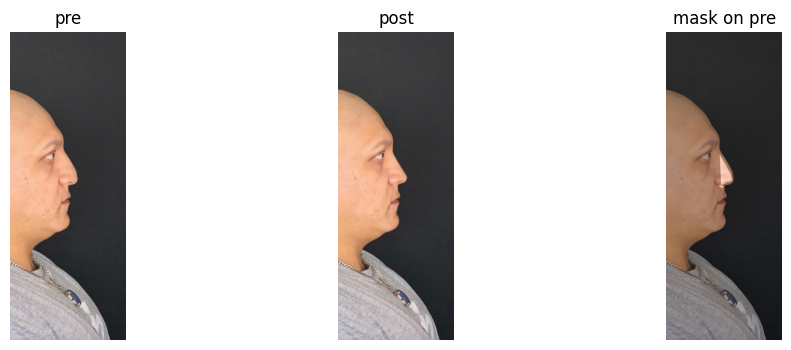

In [34]:
from pathlib import Path
import cv2, numpy as np

A = Path("/workspace/processed/train/A")
B = Path("/workspace/processed/train/B")
M = Path("/workspace/nose_mask")   # or your train mask dir

pairs = []
missing_b, missing_m = [], []

for pre in sorted(A.glob("*.jpeg")):
    # build expected post + mask names
    post = B / pre.name.replace("pre_", "post_")
    mask = M / pre.name  # mask uses the *pre* filename in your loader

    if not post.exists():
        missing_b.append((pre.name, post.name))
    if not mask.exists():
        missing_m.append((pre.name, mask.name))
    pairs.append((pre, post, mask))

print(f"total pre: {len(pairs)} | missing post: {len(missing_b)} | missing mask: {len(missing_m)}")

# Check mean mask coverage
covs = []
for _,_, maskp in pairs[:2000]:   # sample or remove slice to check all
    m = cv2.imread(str(maskp), cv2.IMREAD_GRAYSCALE)
    if m is None: continue
    covs.append((m>127).mean())
print("mean mask coverage:", np.mean(covs) if covs else None)

# Visualize one triplet to sanity check alignment
i = 0
pre, post, maskp = pairs[i]
img = cv2.imread(str(pre))[:,:,::-1]    # BGR->RGB
tgt = cv2.imread(str(post))[:,:,::-1]
msk = cv2.imread(str(maskp), cv2.IMREAD_GRAYSCALE)
msk_rgb = np.stack([msk]*3, axis=-1)
overlay = (0.7*img + 0.3*(msk_rgb>127)*255).astype(np.uint8)

import matplotlib.pyplot as plt
plt.figure(figsize=(12,4))
plt.subplot(1,3,1); plt.title("pre");  plt.imshow(img);  plt.axis("off")
plt.subplot(1,3,2); plt.title("post"); plt.imshow(tgt);  plt.axis("off")
plt.subplot(1,3,3); plt.title("mask on pre"); plt.imshow(overlay); plt.axis("off")
plt.show()

In [102]:
device = "cuda" if torch.cuda.is_available() else "cpu"
patch_size = 8

test_img_dir    = "/workspace/processed/val/A"
test_mask_dir   = "/workspace/test_nose_mask"
test_target_dir = "/workspace/processed/val/B"

test_ds = NoseFolderDataset(test_img_dir, test_mask_dir, test_target_dir, size=256)
test_loader = DataLoader(test_ds, batch_size=4, shuffle=False, num_workers=4, pin_memory=True)

# Run
run_test_gan(
    ckpt_path="ckpts_gan/best_l1_mask.pt",
    test_loader=test_loader,
    device=device,
    patch_size=patch_size,
    save_dir="/workspace/results_gan",
    panel_size=256
)

Saved test panels to: /workspace/results_gan


In [31]:
import face_alignment
fa = face_alignment.FaceAlignment(face_alignment.LandmarksType.TWO_D, device=device, flip_input=False)

def create_nose_mask(image_path, save_path, log):
    try:
        img = cv2.imread(image_path)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
        preds = fa.get_landmarks(img_rgb)
        if preds is None:
            return False
            
    except Warning as w:  # Catch warnings as exceptions
        return False

    landmarks = preds[0]
    nose_points = landmarks[27:36]  # indexes 27–35 in 0-based Python index

    mask = np.zeros(img.shape[:2], dtype=np.uint8)
    cv2.fillConvexPoly(mask, np.int32(nose_points), 255)

    cv2.imwrite(save_path, mask)
    return True

Downloading: "https://www.adrianbulat.com/downloads/python-fan/s3fd-619a316812.pth" to /root/.cache/torch/hub/checkpoints/s3fd-619a316812.pth


100.0%
Downloading: "https://www.adrianbulat.com/downloads/python-fan/2DFAN4-cd938726ad.zip" to /root/.cache/torch/hub/checkpoints/2DFAN4-cd938726ad.zip
100.0%


In [33]:
from pathlib import Path
import cv2, numpy as np, os

A = Path("/workspace/processed/train/A")
M = Path("/workspace/nose_mask")
M.mkdir(parents=True, exist_ok=True)

missing = []
for pre in sorted(A.glob("*.jpeg")):
    mpath = M/pre.name
    if not mpath.exists():
        missing.append(pre)

print("missing:", len(missing))

def dilate_binary(mask, k=11, iters=2):
    k = max(3, int(k) | 1)  # odd
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (k, k))
    return cv2.morphologyEx(mask, cv2.MORPH_DILATE, kernel, iterations=iters)

# re-run your create_nose_mask but with post-dilation
for pre in missing:
    out = str(M/pre.name)
    ok = create_nose_mask(str(pre), out, log=None)  # your function
    if ok:
        m = cv2.imread(out, cv2.IMREAD_GRAYSCALE)
        if m is not None:
            H, W = m.shape
            # adaptive dilation based on image size
            k = max(7, int(0.03 * max(H, W)) | 1)
            m = dilate_binary(m, k=k, iters=2)
            cv2.imwrite(out, m)
    else:
        # last-resort: write a blank mask so you can spot and skip later
        # (better: manually mask these 29 or try another detector)
        blank = np.zeros((256,256), np.uint8)
        cv2.imwrite(out, blank)

missing: 0


In [132]:
@torch.no_grad()
def debug_identity(model, ds, device, patch_size=8, k=4):
    model.eval()
    for i in range(k):
        batch = [ds[i]]
        batch = {k: torch.stack([d[k] for d in batch]) if isinstance(ds[i][k], torch.Tensor) else [d[k] for d in batch] for k in ds[i]}
        x    = batch["input"].to(device)
        m    = batch["mask"].to(device)
        y    = batch["target"].to(device)

        pm   = mask_to_patch_mask(m, patch_size)
        pred = model(x, patch_mask=pm).clamp(0,1)

        diff_all  = (pred - y).abs().mean().item()
        diff_mask = ((pred - y).abs() * m).sum().item() / (m.sum().item() + 1e-6)
        diff_in   = (pred - x[:,:3]).abs().mean().item()
        print(f"[{i}] L1(pred,target): all={diff_all:.4f} mask={diff_mask:.4f} | L1(pred,input)={diff_in:.4f}")

In [133]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 2. dataset (e.g. validation set)
val_img_dir    = "/workspace/processed/val/A"
val_mask_dir   = "/workspace/test_nose_mask"
val_target_dir = "/workspace/processed/val/B"
ds = NoseFolderDataset(val_img_dir, val_mask_dir, val_target_dir, size=256)

# 3. model
model = NoseTransformer(in_ch=4, out_ch=3, embed_dim=512,
                        patch_size=8, depth=6, num_heads=8).to(device)
ckpt = torch.load("/workspace/ckpts/best_l1_mask.pt", map_location=device)
state_dict = ckpt["model"] if "model" in ckpt else ckpt
model.load_state_dict(state_dict, strict=False)

# 4. run debug_identity
debug_identity(model, ds, device, patch_size=8, k=4)

[0] L1(pred,target): all=0.0141 mask=0.0820 | L1(pred,input)=0.0001
[1] L1(pred,target): all=0.0260 mask=0.1567 | L1(pred,input)=0.0002
[2] L1(pred,target): all=0.0372 mask=0.0732 | L1(pred,input)=0.0001
[3] L1(pred,target): all=0.0050 mask=0.4804 | L1(pred,input)=0.0001


In [138]:
@torch.no_grad()
def visualize_changes(model, ds, device, patch_size=8, k=4, save_dir="viz_changes"):
    """
    Overlay heatmap of changes (prediction vs input) on top of the input image.
    Saves PNGs into save_dir.
    """
    os.makedirs(save_dir, exist_ok=True)
    model.eval()

    to_pil = T.ToPILImage()

    for i in range(min(k, len(ds))):
        sample = ds[i]
        x = sample["input"].unsqueeze(0).to(device)   # (1,4,H,W)
        m = sample["mask"].unsqueeze(0).to(device)    # (1,1,H,W)
        pm = mask_to_patch_mask(m, patch_size)
        pred = model(x, patch_mask=pm).clamp(0,1)     # (1,3,H,W)

        # pixelwise abs diff from input RGB
        diff = (pred - x[:,:3]).abs().mean(1, keepdim=True)  # (1,1,H,W)

        # normalize diff to [0,1]
        d = (diff / (diff.max() + 1e-8)).cpu()[0]    # (1,H,W)

        # build heatmap overlay: input as RGB, diff as red channel
        inp = x[0,:3].cpu()                          # (3,H,W)
        heat = torch.zeros_like(inp)                 # (3,H,W)
        heat[0] = d[0]                               # red channel = diff intensity

        overlay = (0.7*inp + 0.3*heat).clamp(0,1)    # blend input + red heatmap

        save_path = os.path.join(save_dir, f"diff_{i}.png")
        to_pil(overlay).save(save_path)
        print(f"Saved {save_path}")

In [140]:
# pick device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# reuse your test dataset
test_img_dir   = "/workspace/processed/val/A"
test_mask_dir  = "/workspace/test_nose_mask"
test_target_dir= "/workspace/processed/val/B"

test_ds = NoseFolderDataset(test_img_dir, test_mask_dir, test_target_dir, size=256)

# load model
model = NoseTransformer(in_ch=4, out_ch=3, embed_dim=512, patch_size=8,
                        depth=6, num_heads=8).to(device)
ckpt = torch.load("/workspace/ckpts_v2.2/best_l1_mask.pt", map_location=device)


# run visualization
visualize_changes(model, test_ds, device, patch_size=8, k=4, save_dir="viz_changes")

Saved viz_changes/diff_0.png
Saved viz_changes/diff_1.png
Saved viz_changes/diff_2.png
Saved viz_changes/diff_3.png
